In [1]:
import pandas as pd
import shap
import xgboost

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
with open('../data/columns.txt') as f:
    feature_cols = f.read().split(', ')[5:]

In [3]:
target = 'alc'

In [4]:
train_df = pd.read_csv('../data/train_set.csv')
dev_df = pd.read_csv('../data/dev_set.csv')
test_df = pd.read_csv('../data/test_set.csv')

In [5]:
# train XGBoost model
model = xgboost.XGBClassifier().fit(train_df[feature_cols], train_df[target])

# compute SHAP values
explainer = shap.Explainer(model, train_df[feature_cols])
shap_values = explainer(train_df[feature_cols])

 98%|===================| 10048/10227 [00:40<00:00]       

In [41]:
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [49]:
xgb_model = xgboost.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params,
                            random_state=42,
                            n_iter=100,
                            cv=3,
                            verbose=1, n_jobs=1, return_train_score=True)

search.fit(train_df[feature_cols], train_df[target])

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.722 (std: 0.003)
Parameters: {'colsample_bytree': 0.9486212527455787, 'gamma': 0.17837666334679464, 'learning_rate': 0.11428035290621423, 'max_depth': 5, 'n_estimators': 144, 'subsample': 0.6563696899899051}



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

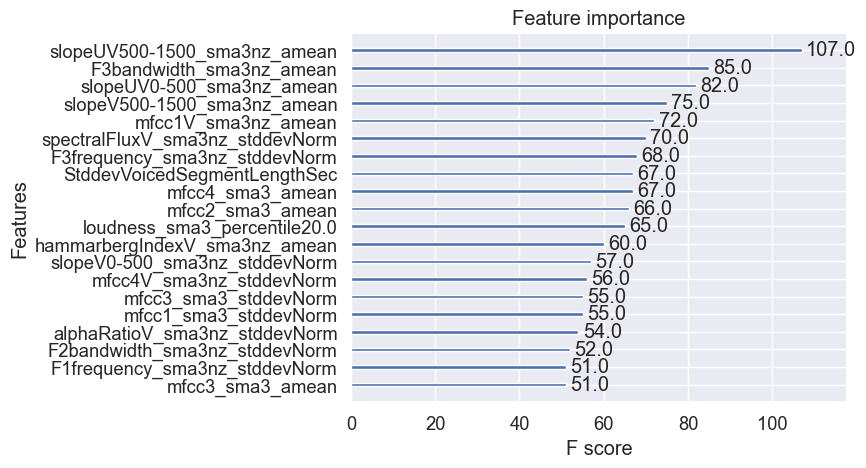

In [57]:
xgboost.plot_importance(search.best_estimator_, max_num_features=20)

In [ ]:
xgboost.XGBClassifier()

In [62]:
xgb_model = xgboost.XGBClassifier(colsample_bytree=0.9486212527455787, gamma=0.17837666334679464,
                                  learning_rate=0.11428035290621423, max_depth=5, n_estimators=144,
                                  subsample=0.6563696899899051).fit(train_df[feature_cols], train_df[target])

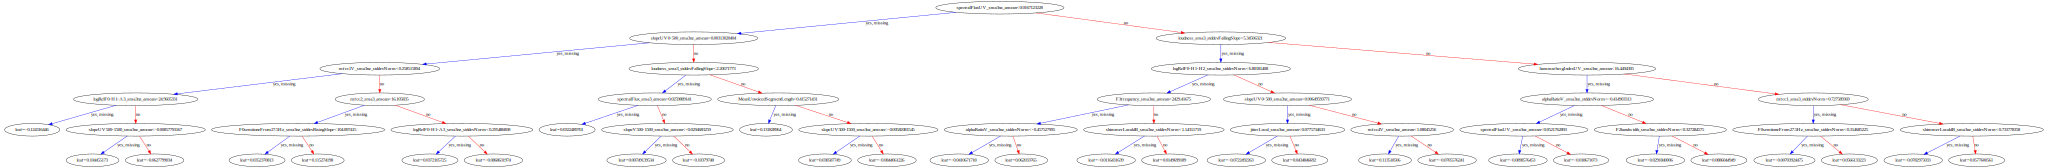

In [63]:
xgboost.to_graphviz(xgb_model, num_trees=search.best_estimator_.best_iteration)

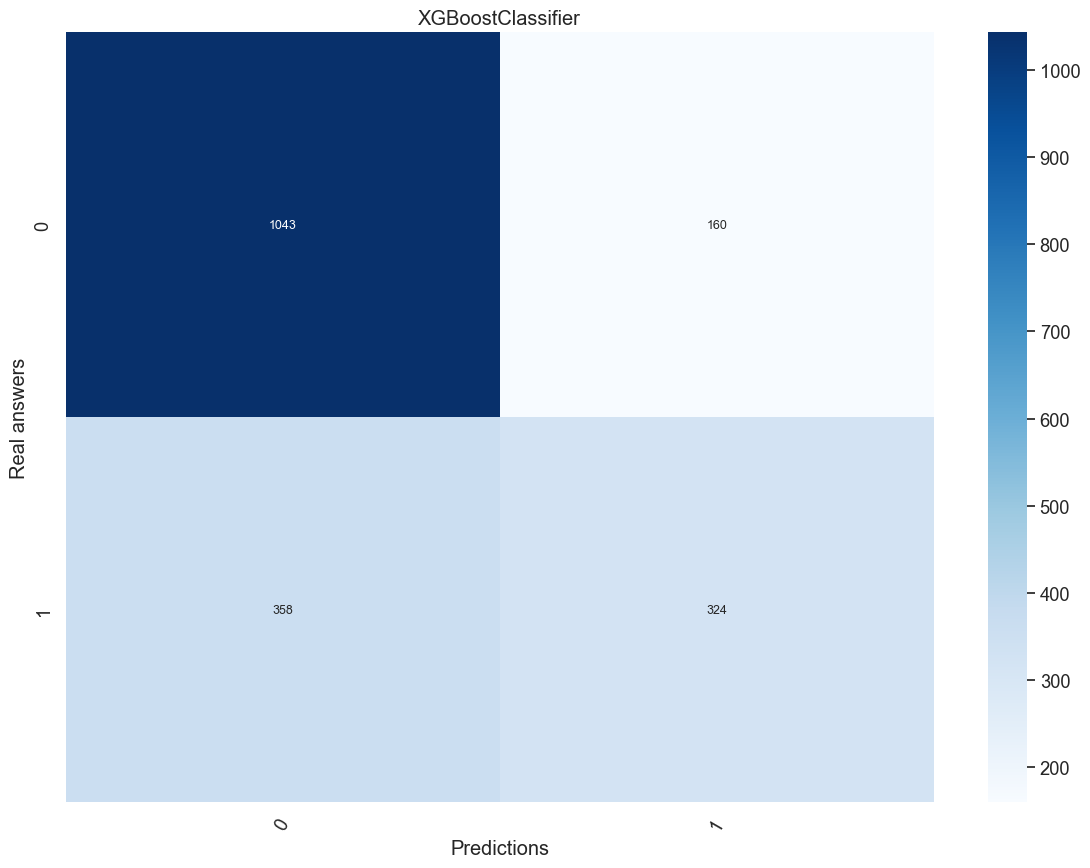

In [64]:
test_df['predicted'] = search.best_estimator_.predict(test_df[feature_cols])
visualize(test_df[target],
          test_df['predicted'],
          labels_sorted,
          algorithm='XGBoostClassifier',
          image_path='../experiments_test')

In [67]:
count_metrics(test_df['alc'], test_df['predicted'], 'XGBoostClassifier')

{'algorithm': 'XGBoostClassifier',
 'precision': 0.67,
 'recall': 0.48,
 'f1_score': 0.56,
 'f1_score_weighted': 0.71,
 'accuracy': 0.73}

In [ ]:
import graphviz

cancer = load_breast_cancer()

X = cancer.data
y = cancer.target

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

xgb.plot_importance(xgb_model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

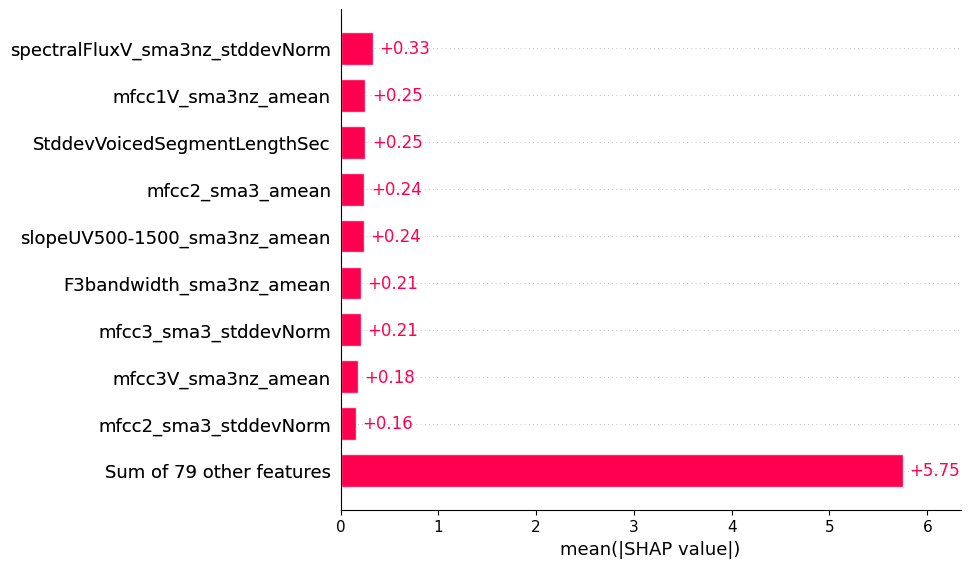

In [6]:
shap.plots.bar(shap_values)

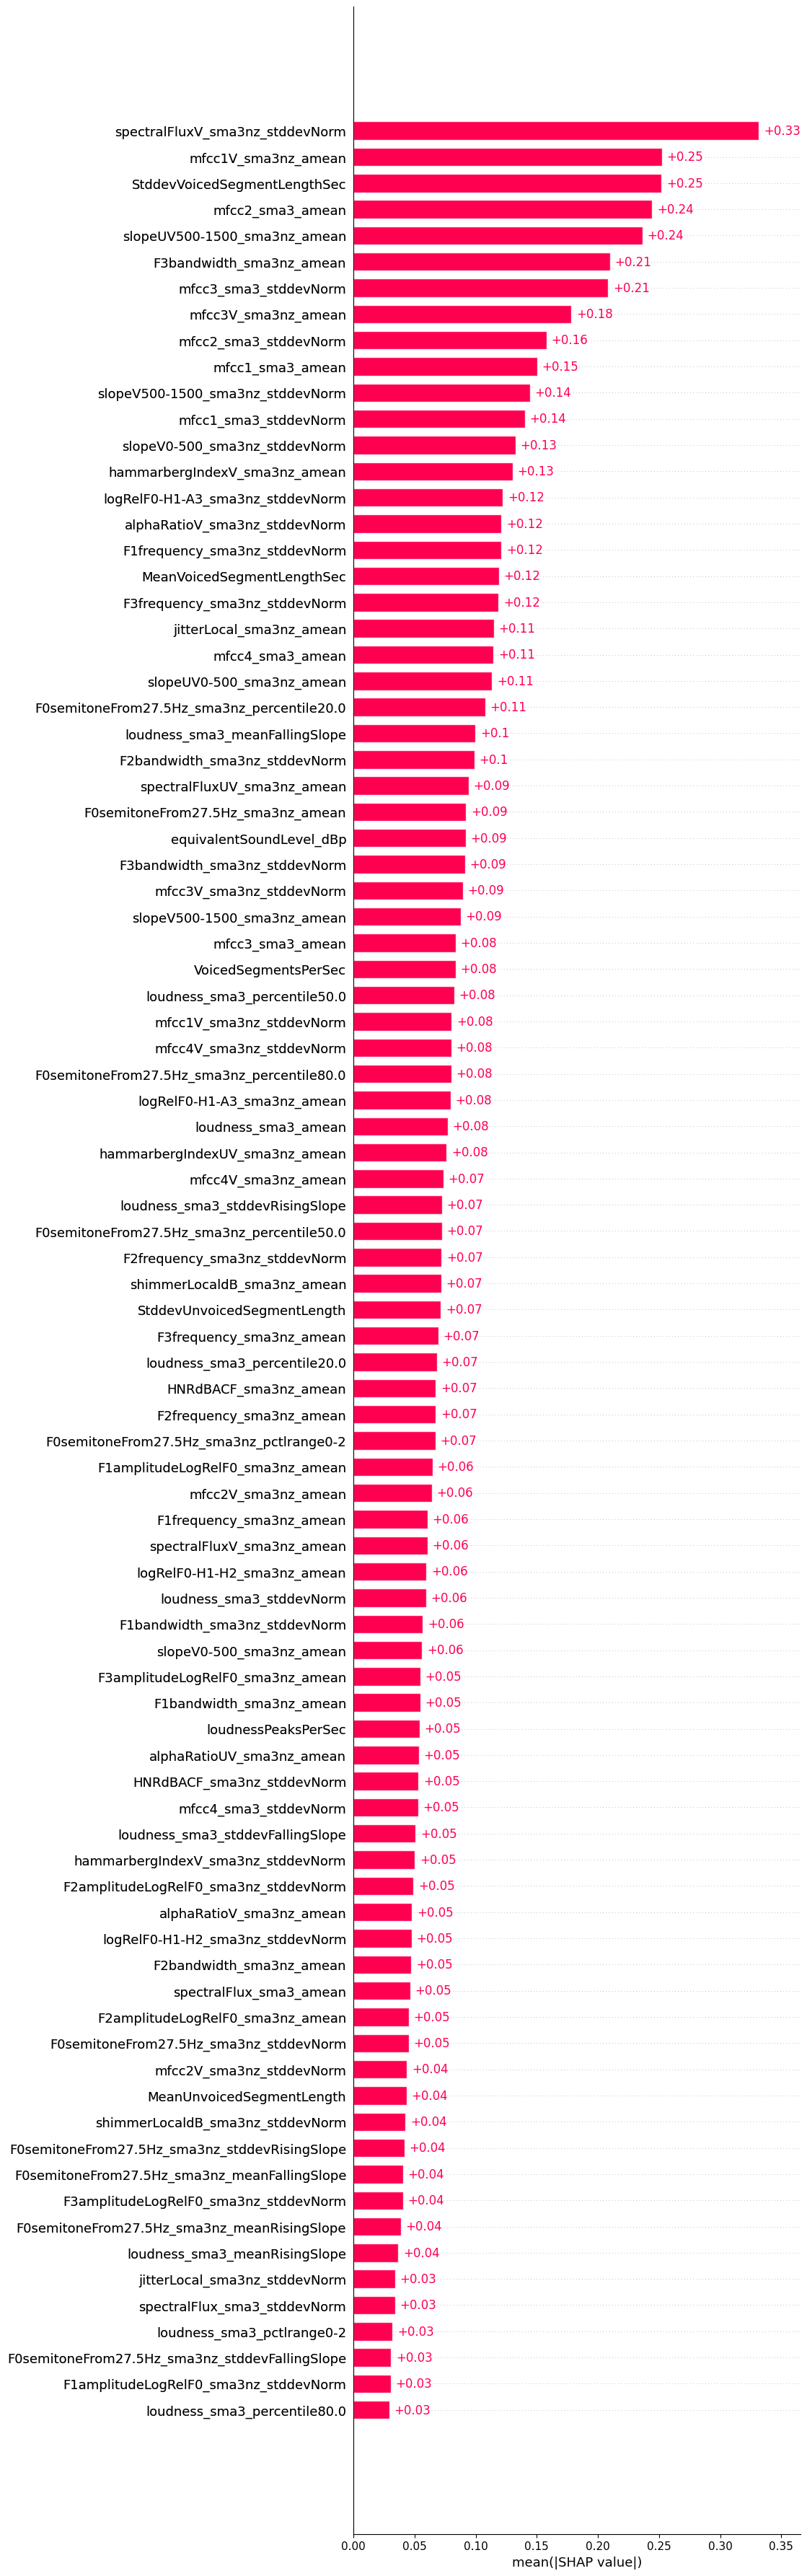

In [8]:
shap.plots.bar(shap_values, max_display=len(feature_cols))

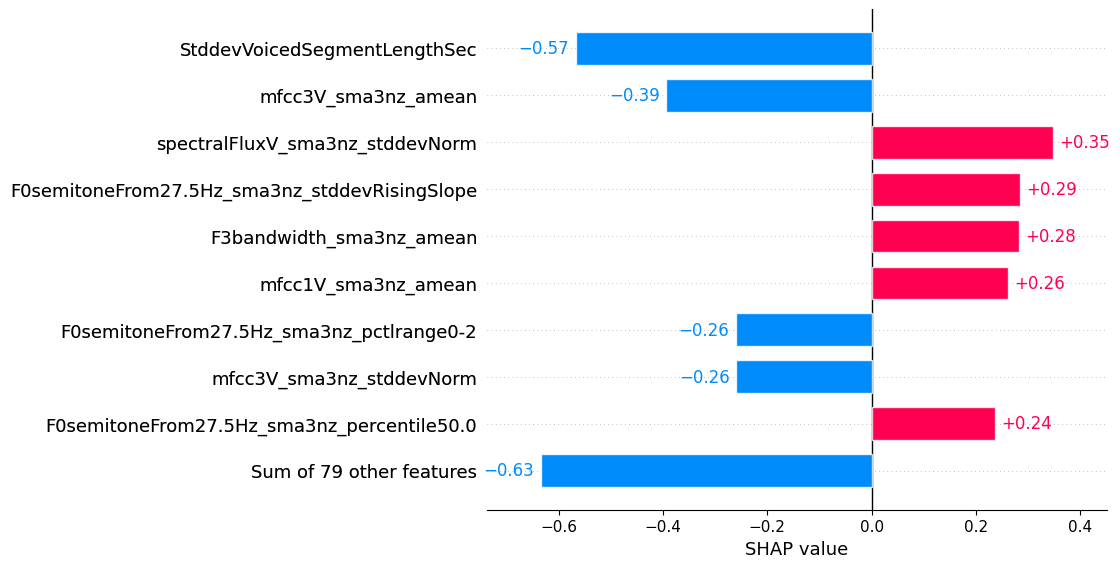

In [9]:
shap.plots.bar(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


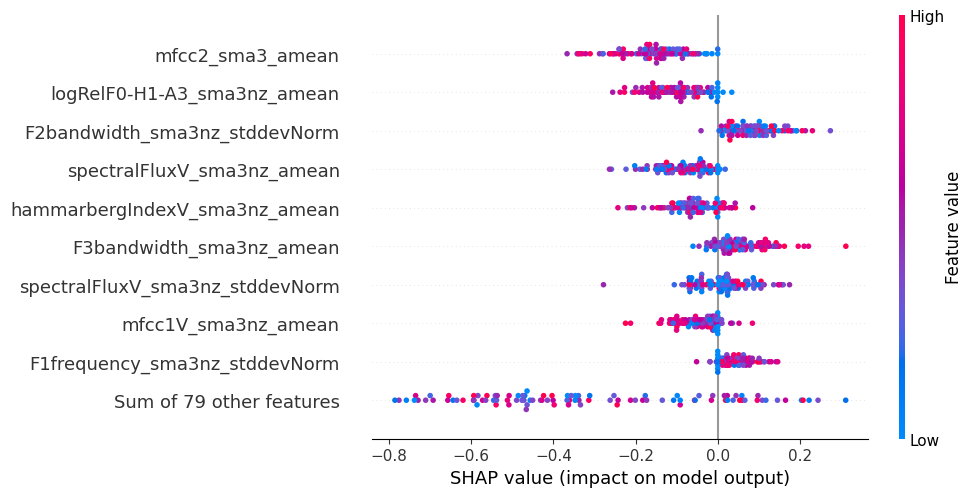

In [10]:
def custom_masker(mask, x):
    return (x * mask).reshape(1,len(x)) # in this simple example we just zero out the features we are masking

# compute SHAP values
explainer = shap.Explainer(model.predict_proba, custom_masker)
shap_values = explainer(train_df[feature_cols][:100])

# plot the SHAP values for the positive class
shap.plots.beeswarm(shap_values[...,1])

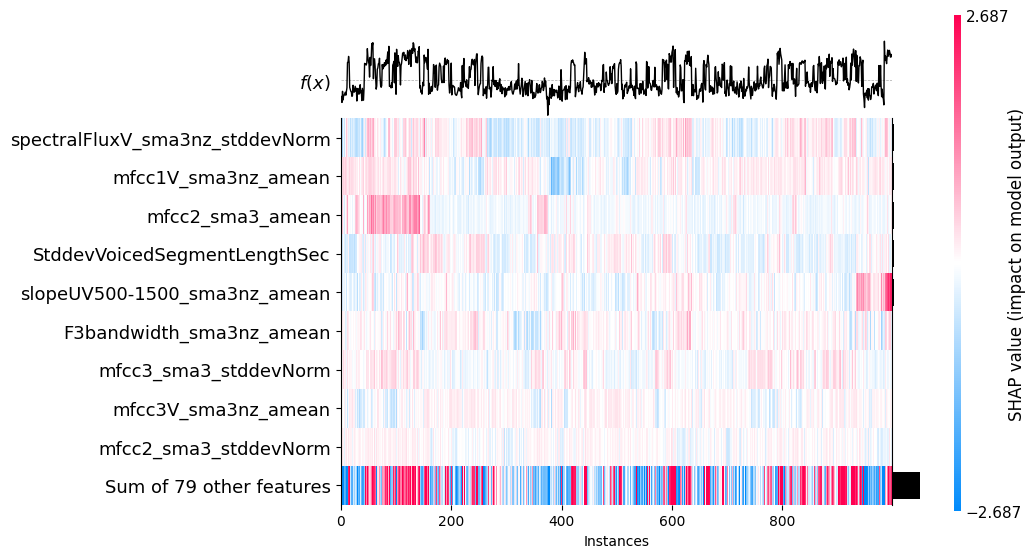

In [12]:
explainer = shap.Explainer(model, train_df[feature_cols])
shap_values = explainer(train_df[feature_cols][:1000])
shap.plots.heatmap(shap_values)

In [14]:
test_df['predicted'] = model.predict(test_df[feature_cols])

In [22]:
from functions_for_ML_experiments import visualize, count_metrics
import seaborn as sn
from sklearn.metrics import classification_report

In [17]:
labels_sorted = [sorted(train_df[target].unique())]

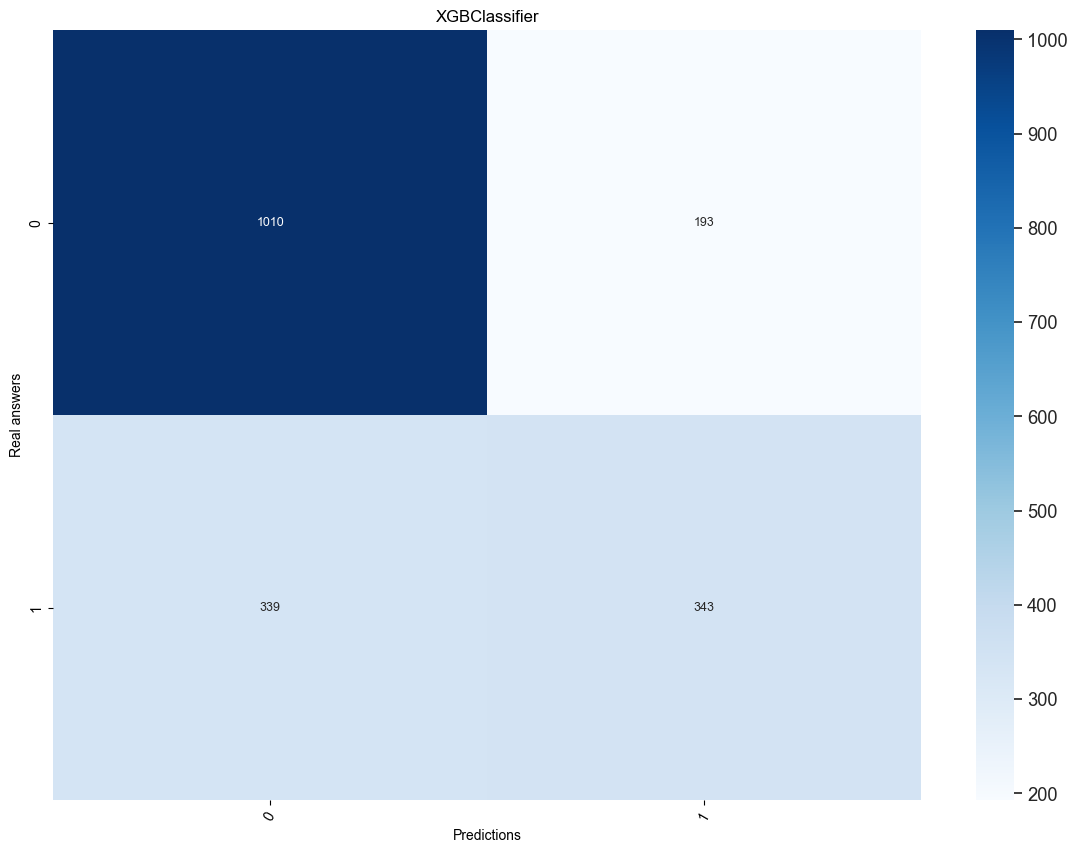

In [18]:
visualize(test_df[target],
          test_df['predicted'],
          labels_sorted,
          algorithm='XGBClassifier',
          image_path='../experiments_test')

In [20]:
pd.DataFrame(count_metrics(test_df[target], test_df['predicted'],'XGBCLASSIFIER'),  index=[0])

,algorithm,precision,recall,f1_score,f1_score_weighted,accuracy
0,XGBCLASSIFIER,0.64,0.5,0.56,0.71,0.72


In [68]:
print(classification_report(test_df[target], test_df['predicted']))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1203
           1       0.67      0.48      0.56       682

    accuracy                           0.73      1885
   macro avg       0.71      0.67      0.68      1885
weighted avg       0.72      0.73      0.71      1885



In [69]:
import numpy as np
bins = [17, 26, 35, 50, np.inf]
names = ['<26', '26-35', '36-50', '50+']

test_df ['AgeRange'] = pd.cut(test_df ['age'], bins, labels=names)

In [70]:
test_df[(test_df['predicted']==0) & (test_df[target]==1)]['AgeRange'].value_counts()

AgeRange
26-35    185
<26      122
36-50     31
50+       20
Name: count, dtype: int64

In [71]:
test_df[(test_df['predicted']==1) & (test_df[target]==0)]['AgeRange'].value_counts()

AgeRange
<26      99
26-35    50
50+       7
36-50     4
Name: count, dtype: int64

In [72]:
test_df[(test_df['predicted']==1) & (test_df[target]==0)]['ges'].value_counts()

ges
f6     67
f5     44
f1     19
f2     14
f3      9
f10     6
f8      1
Name: count, dtype: int64

In [73]:
test_df[(test_df['predicted']==0) & (test_df[target]==1)]['ges'].value_counts()

ges
f5     128
f10     93
f1      64
f6      49
f2      18
f9       5
f4       1
Name: count, dtype: int64

In [74]:
test_df[(test_df['predicted']==0) & (test_df[target]==1)]['content'].value_counts()

content
N    70
C    61
A    54
R    52
T    49
P    35
Q    29
S     8
Name: count, dtype: int64

In [75]:
test_df[(test_df['predicted']==1) & (test_df[target]==0)]['content'].value_counts()

content
T    32
R    27
C    26
A    24
N    19
P    15
Q    11
S     6
Name: count, dtype: int64

In [76]:
test_df[(test_df['predicted']==0) & (test_df[target]==1)]['drh'].value_counts()

drh
moderate    206
light       136
heavy        16
Name: count, dtype: int64

In [77]:
test_df[(test_df['predicted']==1) & (test_df[target]==0)]['drh'].value_counts()

drh
light       105
moderate     49
heavy         6
Name: count, dtype: int64